In [1]:
from IPython.display import Math

# Manipulação dos dados
import numpy as np
import pandas as pd
 
# Gráficos
import matplotlib as mpl
import matplotlib.pyplot as plt
 
import seaborn as sns
sns.set_theme()

np.random.seed(42)

In [2]:
# Ajustes nas configurações padrões dos plots
mpl.rcParams['figure.figsize'] = (8, 8)
mpl.rcParams['font.size'] = 14
mpl.rcParams['legend.fontsize'] = 14

# Processos Gaussianos para Regressão

Baseado em: https://gpflow.readthedocs.io/en/develop/notebooks/basics/regression.html

## Preparação dos dados

Carregando dataset

In [3]:
dataset = pd.read_csv('housesToRentProcessed.csv')

dataset = dataset[(dataset['y con + alu'] < 1550) & (dataset['y con + alu'] > 1490) & (dataset['area'] < 50)]
dataset = dataset.sort_values(['area', 'y con + alu'])

dataset#.head()
dataset = dataset.groupby('area').first().reset_index()

Definindo `X` e `y`

In [4]:
X = dataset[[
    #'São Paulo', 'Porto Alegre', 'Rio de Janeiro', 'Campinas', 'Belo Horizonte', 
    'area',
    #'rooms', 'bathroom', 'parking spaces', 'floor', 'isHouse', 'animal', 'furniture',
]].values
Y = dataset[['y con + alu']].values

X = X[0:10]
Y = Y[0:10]

X = X.astype(np.float64)
Y = Y.astype(np.float64)

Normalização dos dados abaixo foi simplificada, somente para testar o modelo

In [5]:
from sklearn.preprocessing import MinMaxScaler

Scaler = MinMaxScaler

X = Scaler().fit_transform(X)
Y = Scaler().fit_transform(Y)

## Definição do modelo

In [6]:
import gpflow
import tensorflow as tf
from gpflow.utilities import print_summary

from trabalho.modelos.gp import GP


## Treinamento do modelo

In [7]:
from trabalho.util.metrica import rmse
from trabalho.util.metrica import nlpd


name,class,transform,prior,trainable,shape,dtype,value
GPR.mean_function.A,Parameter,Identity,,True,"(1, 1)",float64,[[-0.04246858]]
GPR.mean_function.b,Parameter,Identity,,True,"(1,)",float64,[0.48060227]
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,1.9387159467851726e-10
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,14.215243144642532
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,0.09174163330507734


0.302888643494378 0.6601411410184606


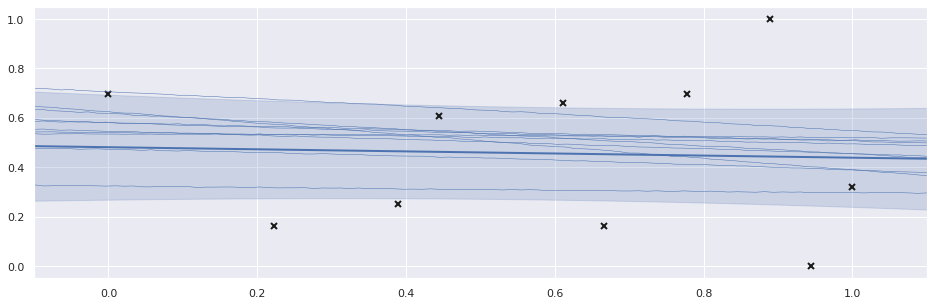

In [11]:
gp = GP(
    #kernel=gpflow.kernels.Polynomial(degree=3.,active_dims=[0]) + gpflow.kernels.Polynomial(degree = 3., active_dims=[.9]),
    #kernel=gpflow.kernels.SquaredExponential(),
    kernel=gpflow.kernels.Matern52(),
    #mean_function=gpflow.mean_functions.Zero(),
    mean_function=gpflow.mean_functions.Linear(2),
    #mean_function=None,
)

gp.fit(X, Y)
gp.modelo.kernel.variance = np.float64(1.)

Y_predict, Y_vars = gp.predict(X)
print(rmse(Y, Y_predict), nlpd(Y, Y_predict, Y_vars))

## generate test points for prediction
xx = np.linspace(-0.1, 1.1, 100).reshape(100, 1)

## predict mean and variance of latent GP at test points
mean, var = gp.predict_f(xx)

tf.random.set_seed(1)
samples = gp.modelo.predict_f_samples(xx, 10)

## plot
plt.figure(figsize=(16, 5))
plt.plot(X, Y, "kx", mew=2)
plt.plot(xx, mean, "C0", lw=2)
plt.fill_between(xx[:, 0], mean[:, 0] - 1.96 * np.sqrt(var[:, 0]), mean[:, 0] + 1.96 * np.sqrt(var[:, 0]), color="C0", alpha=0.2,)

plt.plot(xx, samples[:, :, 0].numpy().T, "C0", linewidth=0.5);
plt.xlim(-0.1, 1.1);